In [105]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os

In [106]:
# Look into the data directory
# first, generate figure.
data_dir = r'M:\cs230_project\virufy_small_dataset_12s_classification'
#print(os.listdir(data_dir))

#Training data directory
train_dir = (data_dir + '/train')
print('Classes:')
print(os.listdir(train_dir))

#Test data directory
test_dir = (data_dir + '/test')

Classes:
['detectable', 'nondetectable']


In [107]:
# create the datasets

In [108]:
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset

In [109]:
#Transformations aplied to test DS.
train_tf = tt.Compose([ tt.Grayscale(num_output_channels = 1),         
    tt.ColorJitter(brightness=0),
    tt.Resize(size=(150,150)),
    tt.RandomRotation(3),
    tt.ToTensor(),            
])

#Transformations aplied to test DS.
test_tf= tt.Compose([   tt.Grayscale(num_output_channels = 1), 
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

In [110]:
train_ds = ImageFolder(train_dir,train_tf)
test_ds = ImageFolder(test_dir,test_tf)

len(train_ds), len(test_ds)

(3517, 878)

In [111]:
img,label=train_ds[0]
img.shape

torch.Size([1, 150, 150])

In [112]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))
    

In [9]:
print('Training dataset information:')
ds_info(train_ds)

Training dataset information:
Size of the dataset:3517
Number of classes:2
Samples for every class:
detectable : 1757
nondetectable : 1760


In [10]:
print('Test dataset information:')
ds_info(test_ds)


Test dataset information:
Size of the dataset:878
Number of classes:2
Samples for every class:
detectable : 439
nondetectable : 439


In [113]:
batch_size = 254

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=False,
    pin_memory=True
)

In [114]:
from torchvision.utils import make_grid

In [115]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

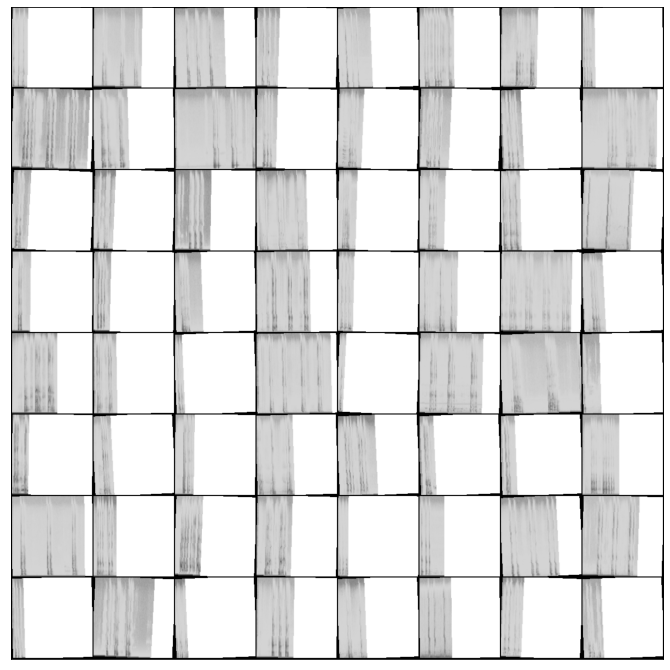

In [116]:
%matplotlib inline
show_batch(train_dl)

In [117]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [118]:
device = get_default_device() #Getting the device
device

train_dl = DeviceDataLoader(train_dl, device) #Transfering train data to GPU
test_dl = DeviceDataLoader(test_dl, device)   #Transfering test data to GPU

In [119]:
# create network

In [120]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [121]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [122]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['train_acc'],result['val_loss'], result['val_acc']))

In [123]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        self.dropout = nn.Dropout(0)
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.dropout(out)
        
        out = self.res1(out) + out
        out = self.dropout(out)
        
        out = self.conv3(out)
        out = self.dropout(out)
        
        out = self.conv4(out)
        out = self.dropout(out)
        
        out = self.res2(out) + out
        out = self.dropout(out)
        
        out = self.classifier(out)
        
        return out

In [124]:
from tqdm.notebook import tqdm

In [125]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_acces = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)['train_loss']
            acc = model.training_step(batch)['train_acc']
            train_losses.append(loss)
            train_acces.append(acc)
            loss.backward()

            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acces).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [126]:
def plot_scores(history):
    train_acc = [x.get('train_acc') for x in history]
    val_scores = [x['val_acc'] for x in history]
    plt.plot(train_acc,'-bx')
    plt.plot(val_scores, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylabel(['Training','Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [127]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [128]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,test_ds.classes[preds[0].item()])

In [129]:
#ResNet9

In [130]:
model = to_device(ResNet9(1,2), device) # two classes 0 and 1
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [131]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 0.6969606876373291, 'val_acc': 0.43208661675453186}]

In [132]:
epochs = 40
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [133]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00005, train_loss: 0.7290,train_acc: 0.5191, val_loss: 0.7521, val_acc: 0.4321


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00010, train_loss: 0.7228,train_acc: 0.5153, val_loss: 0.7444, val_acc: 0.4624


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00018, train_loss: 0.7003,train_acc: 0.5358, val_loss: 0.7643, val_acc: 0.4760


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00027, train_loss: 0.7034,train_acc: 0.5342, val_loss: 0.7671, val_acc: 0.4848


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00039, train_loss: 0.7022,train_acc: 0.5327, val_loss: 0.7030, val_acc: 0.5441


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00052, train_loss: 0.7266,train_acc: 0.5329, val_loss: 0.7180, val_acc: 0.5048


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00064, train_loss: 0.7051,train_acc: 0.5293, val_loss: 0.6985, val_acc: 0.5074


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00076, train_loss: 0.6965,train_acc: 0.5414, val_loss: 0.6931, val_acc: 0.5534


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00086, train_loss: 0.7151,train_acc: 0.5295, val_loss: 0.7289, val_acc: 0.5659


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00093, train_loss: 0.6901,train_acc: 0.5602, val_loss: 0.6908, val_acc: 0.5490


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00098, train_loss: 0.6788,train_acc: 0.5688, val_loss: 0.7079, val_acc: 0.4893


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00100, train_loss: 0.6817,train_acc: 0.5794, val_loss: 0.7105, val_acc: 0.5169


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00100, train_loss: 0.6938,train_acc: 0.5500, val_loss: 0.7262, val_acc: 0.5013


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00099, train_loss: 0.6808,train_acc: 0.5694, val_loss: 0.7044, val_acc: 0.5297


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00097, train_loss: 0.6708,train_acc: 0.5908, val_loss: 0.7343, val_acc: 0.5104


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00095, train_loss: 0.6706,train_acc: 0.5816, val_loss: 0.8240, val_acc: 0.4826


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00092, train_loss: 0.6668,train_acc: 0.5855, val_loss: 0.7658, val_acc: 0.4854


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00089, train_loss: 0.6450,train_acc: 0.6197, val_loss: 0.7391, val_acc: 0.4969


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00085, train_loss: 0.6403,train_acc: 0.6302, val_loss: 0.7153, val_acc: 0.5460


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00081, train_loss: 0.6324,train_acc: 0.6361, val_loss: 0.7189, val_acc: 0.5379


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00077, train_loss: 0.6115,train_acc: 0.6659, val_loss: 0.7847, val_acc: 0.5574


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00072, train_loss: 0.6103,train_acc: 0.6630, val_loss: 0.7542, val_acc: 0.5265


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00067, train_loss: 0.5928,train_acc: 0.6732, val_loss: 0.8042, val_acc: 0.5733


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00061, train_loss: 0.5863,train_acc: 0.6803, val_loss: 0.7475, val_acc: 0.5496


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00056, train_loss: 0.5438,train_acc: 0.7084, val_loss: 1.1175, val_acc: 0.4869


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00050, train_loss: 0.5458,train_acc: 0.7156, val_loss: 0.7995, val_acc: 0.5116


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00044, train_loss: 0.5036,train_acc: 0.7559, val_loss: 0.8026, val_acc: 0.5604


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00039, train_loss: 0.4777,train_acc: 0.7666, val_loss: 0.8857, val_acc: 0.5324


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00033, train_loss: 0.4287,train_acc: 0.7979, val_loss: 0.9332, val_acc: 0.5285


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00028, train_loss: 0.4070,train_acc: 0.8045, val_loss: 0.9340, val_acc: 0.5246


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00023, train_loss: 0.3532,train_acc: 0.8466, val_loss: 1.0206, val_acc: 0.5281


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00019, train_loss: 0.3147,train_acc: 0.8641, val_loss: 1.0788, val_acc: 0.5383


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00015, train_loss: 0.2571,train_acc: 0.8927, val_loss: 1.2950, val_acc: 0.5234


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00011, train_loss: 0.2320,train_acc: 0.9007, val_loss: 1.3204, val_acc: 0.5281


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00008, train_loss: 0.2194,train_acc: 0.9043, val_loss: 1.4889, val_acc: 0.5293


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00005, train_loss: 0.1819,train_acc: 0.9254, val_loss: 1.4605, val_acc: 0.5395


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00003, train_loss: 0.1487,train_acc: 0.9388, val_loss: 1.6546, val_acc: 0.5317


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00001, train_loss: 0.1461,train_acc: 0.9404, val_loss: 1.7269, val_acc: 0.5447


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00000, train_loss: 0.1280,train_acc: 0.9507, val_loss: 1.7054, val_acc: 0.5356


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00000, train_loss: 0.1226,train_acc: 0.9535, val_loss: 1.7145, val_acc: 0.5396
Wall time: 7min 49s


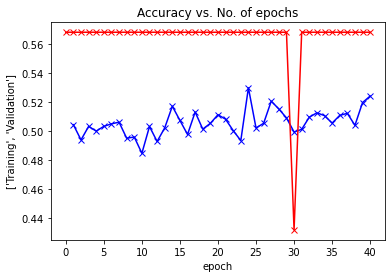

In [103]:
plot_scores(history)

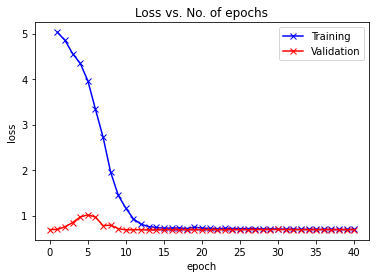

In [104]:
plot_losses(history)

In [78]:
class model18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        self.network.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
model = to_device(model18(), device)
model

In [ ]:
history = [evaluate(model, test_dl)]
history

In [ ]:
epochs = 20
epochs2 = 20
max_lr2 = 0.00005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
model.freeze()

In [ ]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
plot_scores(history)

In [ ]:
plot_losses(history)

In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
plot_scores(history)

In [ ]:
plot_losses(history)

In [ ]:
model